In [1]:
import xarray as xr
import rioxarray as riox
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import geopandas as gpd
import re
import os
import numpy as np
from hlsstack.hls_funcs.masks import shp2mask

In [2]:
save_plots = True

In [3]:
yr = 2023
prefix='cper'

cluster_loc = 'hpc'

if cluster_loc == 'local':
    inDIR_gcloud = 'data/gcloud/'
    inDIR_lta = 'data/ee_lta/'
elif cluster_loc == 'hpc':
    inDIR_gcloud = '/90daydata/cper_neon_aop/hls_nrt/gcloud/'
    inDIR_lta = '/90daydata/cper_neon_aop/hls_nrt/ee_lta/'

In [4]:
ds = riox.open_rasterio(os.path.join(inDIR_gcloud, 'hls_' + prefix + '_' + str(yr) + '_gcloud.nc'), masked=True)#.chunk(sngl_chunks)
ds['date'] = [datetime.strptime(str(x),'%Y-%m-%d %H:%M:%S') for x in ds['date'].values]
ds['date'] = ds['date'].dt.date
#ds = ds.where(ds < ds.attrs['_FillValue'])
ds = ds.where(ds != np.inf)
#ds

In [5]:
ds

<xarray.Dataset>
Dimensions:      (date: 184, y: 325, x: 323)
Coordinates:
  * y            (y) float64 4.993e+06 4.993e+06 4.993e+06 ... 4.98e+06 4.98e+06
  * x            (x) float64 -1.167e+07 -1.167e+07 ... -1.165e+07 -1.165e+07
  * date         (date) object 2023-01-01 2023-01-02 ... 2023-07-02 2023-07-03
    spatial_ref  int64 0
Data variables:
    BARE         (date, y, x) float32 0.25 0.3445 0.3509 ... 0.2797 0.2617 0.25
    GREEN        (date, y, x) float32 0.25 0.0007311 0.0 ... 0.6953 0.7054 0.25
    SD           (date, y, x) float32 0.25 0.5261 0.5005 ... 0.001293 0.25
    LITT         (date, y, x) float32 0.25 0.1287 0.1486 ... 0.03156 0.25
    Biomass      (date, y, x) float32 nan 596.7 422.4 436.5 ... 693.1 791.2 nan
    Biomass_SE   (date, y, x) float32 nan 0.2286 0.2287 ... 0.2543 0.2516 nan
    NDVI         (date, y, x) float32 nan 0.1435 0.1282 ... 0.5983 0.5961 nan
    DRYVEG       (date, y, x) float32 0.5 0.6548 0.6491 ... 0.02504 0.03286 0.5
    NONVEG       (date, y, x) float32 0.5 0.4732 0.4995 ... 0.3041 0.2933 0.5
Attributes:
    _FillValue:  3.402823466385289e+38

In [6]:
yr_comp = 2014
ds_comp = riox.open_rasterio(os.path.join(inDIR_gcloud, 'hls_' + prefix + '_' + str(yr_comp) + '_gcloud.nc'), masked=True)#.chunk(sngl_chunks)
ds_comp['date'] = [datetime.strptime(str(x),'%Y-%m-%d %H:%M:%S') for x in ds_comp['date'].values]
ds_comp['date'] = ds_comp['date'].dt.date
#ds_comp = ds_comp.where(ds_comp < ds.attrs['_FillValue'])
ds_comp = ds_comp.where(ds_comp != np.inf)
ds_comp_dates = (ds_comp['date'] + timedelta(days=365*(yr-yr_comp) + 1)).values
if len(ds_comp_dates) == 366:
    ds_comp_dates = [x for x in ds_comp_dates if x.year == yr]
    ds_comp = ds_comp.where(ds_comp['date'] != datetime(yr_comp, 2, 29).date(), drop=True)

In [7]:
ds_ndvi_lta = riox.open_rasterio(os.path.join(inDIR_lta, prefix + '_ee_ndvi_landsat_wkly_lta.nc'), masked=True)

In [8]:
ds_ndvi_lta['date'] = [datetime.strptime(re.sub('2020', str(yr), str(x)),'%Y-%m-%d %H:%M:%S') for x in ds_ndvi_lta['date'].values]

In [9]:
ds_ndvi_lta['date'] = ds_ndvi_lta['date'].dt.date

In [10]:
ds_ndvi_lta = ds_ndvi_lta.reindex({'y': ds.y, 'x': ds.x}, method='nearest', tolerance=30)#.isnull().all()

In [11]:
cmap = plt.cm.tab10

Text(0.5, 1.0, 'CPER-wide average greenness (NDVI)')

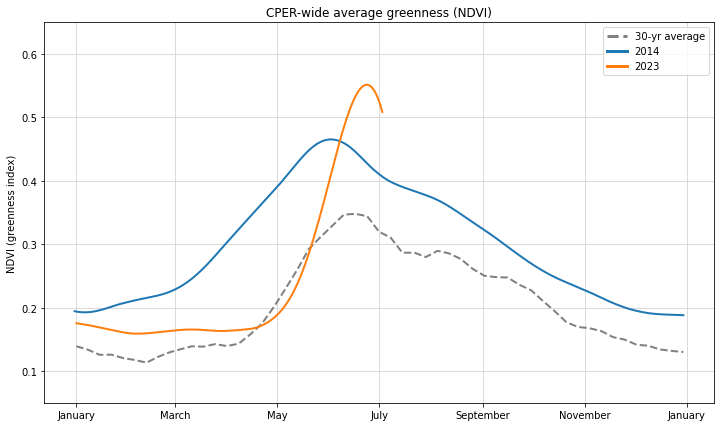

In [12]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(ds_ndvi_lta.date.values, ds_ndvi_lta.mean(dim=['y', 'x']).values, color='grey', linestyle='dashed',  linewidth=2)
ax.plot(ds_comp_dates, ds_comp['NDVI'].mean(dim=['y', 'x']).values,  linewidth=2)
ax.plot(ds.date.values, ds['NDVI'].mean(dim=['y', 'x']).values,  linewidth=2)
ax.grid(color='lightgrey', axis='both')
plt.ylim(0.05, 0.65)
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='grey', linestyle='dashed', lw=3),
                Line2D([0], [0], color=cmap(0), lw=3),
                Line2D([0], [0], color=cmap(1), lw=3)]
ax.legend(custom_lines, ['30-yr average', '2014', '2023'])
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%B')
ax.xaxis.set_major_formatter(myFmt)
plt.ylabel('NDVI (greenness index)')
plt.title('CPER-wide average greenness (NDVI)')
#plt.savefig('/mnt/c/Users/TBGPEA-Sean/Desktop/CARM_NDVI_update_2022.png', dpi=300)

In [13]:
if prefix == 'cper':
    cper_f = '../data/ground/cper_pastures_2017_dissolved.shp'
    cper = gpd.read_file(cper_f).to_crs(ds.rio.crs.to_epsg())
    cper_info = cper[['Pasture', 'geometry']].reset_index(drop=True).reset_index().rename(columns={'index': 'id'})
    past_dict = {row.id+1: row.Pasture for _, row in cper_info.iterrows()}
    past_dict[0] = 'UNK'
    cper_mask_shp = [(row.geometry, row.id+1) for _, row in cper_info.iterrows()]
    cper_mask = shp2mask(shp=cper_mask_shp, 
                         transform=ds.rio.transform(), 
                         outshape=ds['NDVI'].shape[1:], 
                         xr_object=ds['NDVI'])
    past_mask = np.array([past_dict[i] for i in cper_mask.values.flatten()]).reshape(cper_mask.shape)

ds = ds.assign(Pasture=(['y', 'x'], past_mask)).chunk({'y': 50, 'x': 50})
ds = ds.set_coords('Pasture')

In [14]:
np.unique(ds['Pasture'].values)

array(['10SNE', '11NS', '11NW', '12C', '12NE', '12NW', '13E', '13W', '14',
       '15E', '15NWS', '15SW', '17N', '18N', '19N', '19S', '1E', '1W',
       '20SE', '21S', '22E', '22W', '23E', '23W', '24E', '24Strip', '24W',
       '25SE', '26E', '28N', '29-30', '30NW', '30SW', '31E', '32W', '5E',
       '5W', '6EE', '6EW', '7NW', '8NW', '8SE', '8SW', 'CN', 'Crossroads',
       'Elm', 'HQ', 'Headquarters', 'Highway', 'Hilltank', 'Nighthawk',
       'Ridgeline', 'Saltflat', 'Slayton', 'Snowfence', 'South', 'UNK'],
      dtype='<U12')

In [15]:
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
myFmt = mdates.DateFormatter('%B')
from tqdm import tqdm

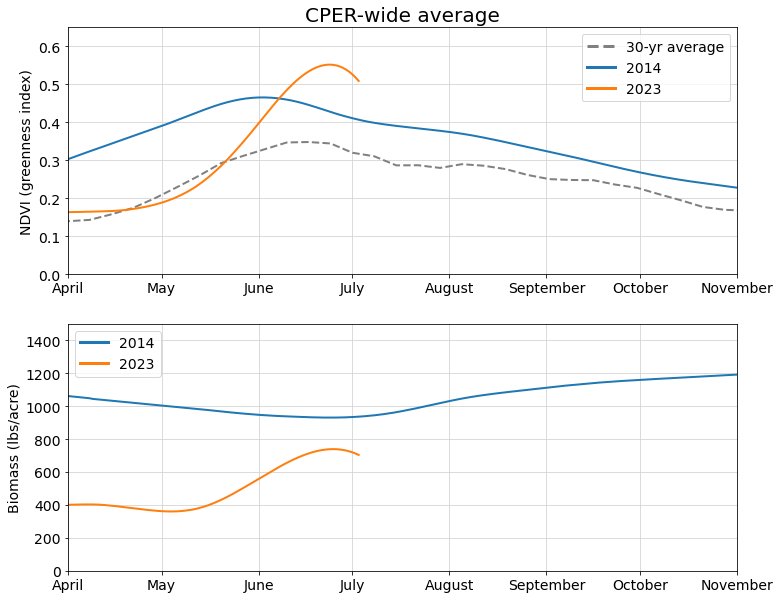

In [16]:
fig, axs = plt.subplots(nrows=2, figsize=(12, 10))
axs[0].plot(ds_ndvi_lta.date.values, ds_ndvi_lta.mean(dim=['y', 'x']).values, color='grey', linestyle='dashed',  linewidth=2)
axs[0].plot(ds_comp_dates, ds_comp['NDVI'].mean(dim=['y', 'x']).values,  linewidth=2)
axs[0].plot(ds.date.values, ds['NDVI'].mean(dim=['y', 'x']).values,  linewidth=2)
axs[0].grid(color='lightgrey', axis='both')
axs[0].set_ylim(0.0, 0.65)

custom_lines = [Line2D([0], [0], color='grey', linestyle='dashed', lw=3),
                Line2D([0], [0], color=cmap(0), lw=3),
                Line2D([0], [0], color=cmap(1), lw=3)]
axs[0].legend(custom_lines, ['30-yr average', '2014', '2023'], fontsize=14)
axs[0].xaxis.set_major_formatter(myFmt)
axs[0].set_ylabel('NDVI (greenness index)')
axs[0].set_title('CPER-wide average', fontdict={'fontsize': 20})

axs[1].plot(ds_comp_dates, ds_comp['Biomass'].mean(dim=['y', 'x']).values,  linewidth=2)
axs[1].plot(ds.date.values, ds['Biomass'].mean(dim=['y', 'x']).values,  linewidth=2)
axs[1].grid(color='lightgrey', axis='both')

custom_lines = [Line2D([0], [0], color=cmap(0), lw=3),
                Line2D([0], [0], color=cmap(1), lw=3)]
axs[1].legend(custom_lines, ['2014', '2023'], fontsize=14)
axs[1].xaxis.set_major_formatter(myFmt)
axs[1].set_ylabel('Biomass (lbs/acre)')
axs[1].set_ylim(0, 1500)

for ax in axs:
    ax.set_xlim([datetime(2023, 4, 1), datetime(2023, 11, 1)])
    for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)
if save_plots:
    plt.savefig('/90daydata/cper_neon_aop/hls_nrt/cper/carm_figs/ndvi_bm_2023vs2014_CPER.png', dpi=300)

In [17]:
if save_plots:
    for past in tqdm(['Elm', 'Crossroads', 'Headquarters', 'Highway', 'Hilltank', 'Nighthawk',
           'Ridgeline', 'Saltflat', 'Snowfence', 'South']):
        fig, axs = plt.subplots(nrows=2, figsize=(12, 10))
        axs[0].plot(ds_ndvi_lta.date.values, ds_ndvi_lta.where(ds['Pasture'] == past).mean(dim=['y', 'x']).values, color='grey', linestyle='dashed',  linewidth=2)
        axs[0].plot(ds_comp_dates, ds_comp['NDVI'].where(ds['Pasture'] == past).mean(dim=['y', 'x']).values,  linewidth=2)
        axs[0].plot(ds.date.values, ds['NDVI'].where(ds['Pasture'] == past).mean(dim=['y', 'x']).values,  linewidth=2)
        axs[0].grid(color='lightgrey', axis='both')
        axs[0].set_ylim(0.0, 0.65)

        custom_lines = [Line2D([0], [0], color='grey', linestyle='dashed', lw=3),
                        Line2D([0], [0], color=cmap(0), lw=3),
                        Line2D([0], [0], color=cmap(1), lw=3)]
        axs[0].legend(custom_lines, ['30-yr average', '2014', '2023'], fontsize=14)
        axs[0].xaxis.set_major_formatter(myFmt)
        axs[0].set_ylabel('NDVI (greenness index)')
        axs[0].set_title(past, fontdict={'fontsize': 20})

        axs[1].plot(ds_comp_dates, ds_comp['Biomass'].where(ds['Pasture'] == past).mean(dim=['y', 'x']).values,  linewidth=2)
        axs[1].plot(ds.date.values, ds['Biomass'].where(ds['Pasture'] == past).mean(dim=['y', 'x']).values,  linewidth=2)
        axs[1].grid(color='lightgrey', axis='both')

        custom_lines = [Line2D([0], [0], color=cmap(0), lw=3),
                        Line2D([0], [0], color=cmap(1), lw=3)]
        axs[1].legend(custom_lines, ['2014', '2023'], fontsize=14)
        axs[1].xaxis.set_major_formatter(myFmt)
        axs[1].set_ylabel('Biomass (lbs/acre)')
        axs[1].set_ylim(0, 1500)

        for ax in axs:
            ax.set_xlim([datetime(2023, 4, 1), datetime(2023, 11, 1)])
            for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
                item.set_fontsize(14)
        plt.savefig('/90daydata/cper_neon_aop/hls_nrt/cper/carm_figs/ndvi_bm_2023vs2014_' + past + '.png', dpi=300)
        plt.close()

100%|██████████| 10/10 [00:20<00:00,  2.04s/it]


100%|██████████| 4/4 [00:00<00:00,  7.33it/s]


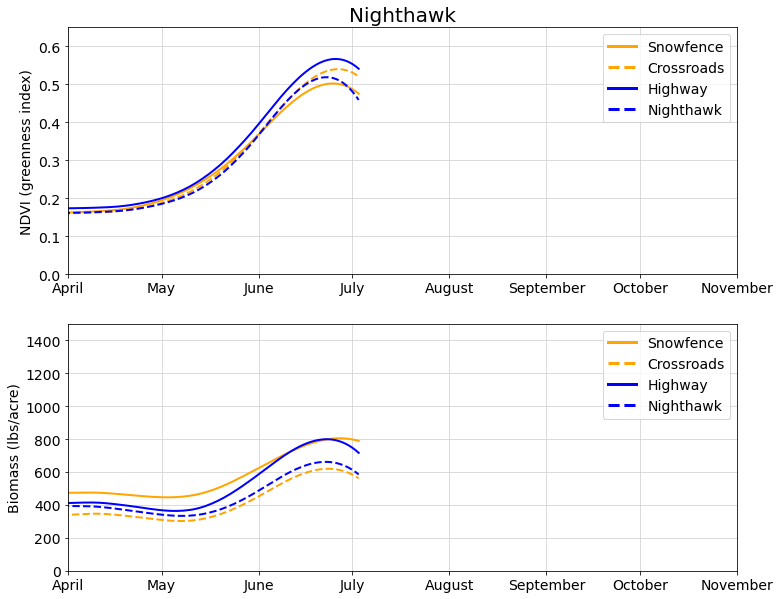

In [18]:
# custom  comparisons between pastures for year
if save_plots:
    fig, axs = plt.subplots(nrows=2, figsize=(12, 10))
    colors = ['orange', 'orange', 'blue', 'blue']
    styles = ['solid', 'dashed', 'solid', 'dashed']
    for idx, past in enumerate(tqdm(['Snowfence', 'Crossroads', 'Highway', 'Nighthawk'])):
        #axs[0].plot(ds_ndvi_lta.date.values, ds_ndvi_lta.where(ds['Pasture'] == past).mean(dim=['y', 'x']).values, color='grey', linestyle='dashed',  linewidth=2)
        #axs[0].plot(ds_comp_dates, ds_comp['NDVI'].where(ds['Pasture'] == past).mean(dim=['y', 'x']).values,  linewidth=2)
        axs[0].plot(ds.date.values, ds['NDVI'].where(ds['Pasture'] == past).mean(dim=['y', 'x']).values, 
                    linewidth=2, color=colors[idx], linestyle=styles[idx])
        axs[0].grid(color='lightgrey', axis='both')
        axs[0].set_ylim(0.0, 0.65)

        #axs[0].legend(custom_lines, ['30-yr average', '2014', '2023'], fontsize=14)
        axs[0].xaxis.set_major_formatter(myFmt)
        axs[0].set_ylabel('NDVI (greenness index)')
        axs[0].set_title(past, fontdict={'fontsize': 20})

        #axs[1].plot(ds_comp_dates, ds_comp['Biomass'].where(ds['Pasture'] == past).mean(dim=['y', 'x']).values,  linewidth=2)
        axs[1].plot(ds.date.values, ds['Biomass'].where(ds['Pasture'] == past).mean(dim=['y', 'x']).values, 
                    linewidth=2, color=colors[idx], linestyle=styles[idx])
        axs[1].grid(color='lightgrey', axis='both')
        axs[1].xaxis.set_major_formatter(myFmt)
        axs[1].set_ylabel('Biomass (lbs/acre)')
        axs[1].set_ylim(0, 1500)

        for ax in axs:
            ax.set_xlim([datetime(2023, 4, 1), datetime(2023, 11, 1)])
            for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
                item.set_fontsize(14)
    custom_lines = [Line2D([0], [0], color='orange', linestyle='solid', lw=3),
                    Line2D([0], [0], color='orange', linestyle='dashed', lw=3),
                    Line2D([0], [0], color='blue', linestyle='solid', lw=3),
                    Line2D([0], [0], color='blue', linestyle='dashed', lw=3)]
    axs[0].legend(custom_lines, ['Snowfence', 'Crossroads', 'Highway', 'Nighthawk'], fontsize=14)
    axs[1].legend(custom_lines, ['Snowfence', 'Crossroads', 'Highway', 'Nighthawk'], fontsize=14)
        #plt.savefig('/90daydata/cper_neon_aop/hls_nrt/cper/carm_figs/ndvi_bm_2023vs2014_' + past + '.png', dpi=300)
        #plt.close()

In [15]:
carm_trm_dict = {}
for past in ['Elm', 'Crossroads', 'Headquarters', 'Highway', 'Hilltank', 'Nighthawk',
       'Ridgeline', 'Saltflat', 'Snowfence', 'South']:
    carm_trm_dict[past] = cper['CARM_Pair'][cper['CARM_Name'] == past].values[0]

In [16]:
df_resid_bm_2022 = ds['Biomass'].sel(date=datetime(2022, 10, 13).date()).to_dataframe(name='Biomass')

In [17]:
df_resid_bm_2022 = df_resid_bm_2022[df_resid_bm_2022['Pasture'].isin(list(carm_trm_dict.keys()) + list(carm_trm_dict.values()))]

In [18]:
df_resid_bm_2022['Treatment'] = df_resid_bm_2022.apply(lambda x: 'CARM' if x['Pasture'] in list(carm_trm_dict.keys()) else 'TRM', axis=1)

In [19]:
df_resid_bm_2022 = df_resid_bm_2022.reset_index()
df_resid_bm_2022 = df_resid_bm_2022.rename(columns={'x': 'coord_x', 'y': 'coord_y'})

In [20]:
import seaborn as sns

In [21]:
past_x_order = [None]*(len(list(carm_trm_dict.keys()))+len(list(carm_trm_dict.values())))
past_x_order[::2] = list(carm_trm_dict.keys())
past_x_order[1::2] = list(carm_trm_dict.values())
past_x_order

['Elm',
 '20SE',
 'Crossroads',
 '25SE',
 'Headquarters',
 '7NW',
 'Highway',
 '24W',
 'Hilltank',
 '26E',
 'Nighthawk',
 '15E',
 'Ridgeline',
 '5E',
 'Saltflat',
 '17N',
 'Snowfence',
 '19N',
 'South',
 '31E']

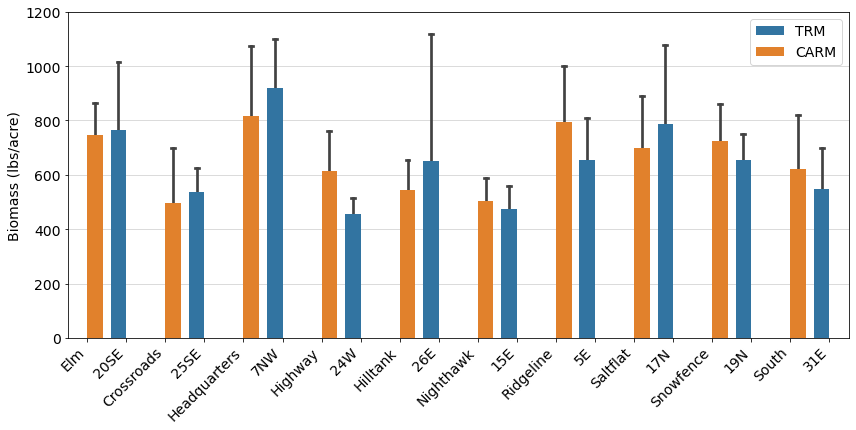

In [38]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.barplot(x='Pasture', y='Biomass', hue='Treatment', data=df_resid_bm_2022,
            order=past_x_order, ax=ax, zorder=10, errorbar='sd', capsize=0.1)
ax.legend(fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_ylim((0, 1200))
ax.set_ylabel('Biomass (lbs/acre)')
ax.set_xlabel('')
ax.grid(color='lightgrey', axis='y', zorder=1)
for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)

if save_plots:
    plt.savefig('/90daydata/cper_neon_aop/hls_nrt/cper/carm_figs/bm_resid_Oct13_2022_CARMvsTRM.png', dpi=300)

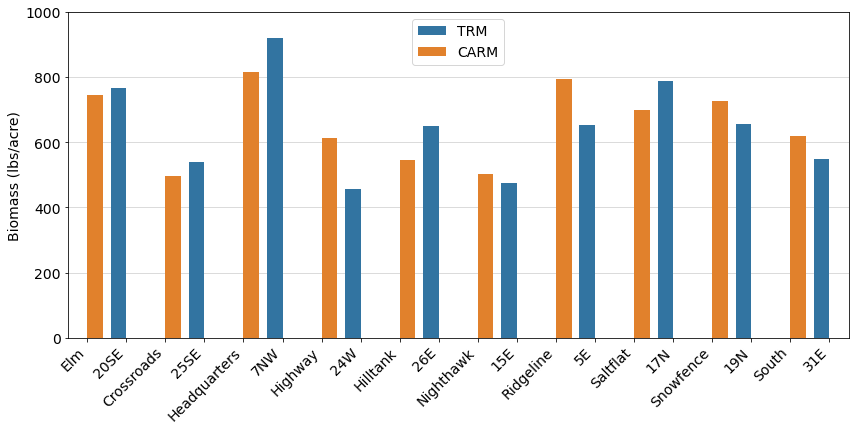

In [39]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.barplot(x='Pasture', y='Biomass', hue='Treatment', data=df_resid_bm_2022,
            order=past_x_order, ax=ax, zorder=10, errorbar=None)
ax.legend(fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_ylim((0, 1000))
ax.set_ylabel('Biomass (lbs/acre)')
ax.set_xlabel('')
ax.grid(color='lightgrey', axis='y', zorder=1)
for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)

if save_plots:
    plt.savefig('/90daydata/cper_neon_aop/hls_nrt/cper/carm_figs/bm_resid_Oct13_2022_CARMvsTRM_no_errorbar.png', dpi=300)

In [ ]:
df_resid_bm_2022_means = df_resid_bm_2022.groupby('Pasture').mean().drop(columns=['coord_y', 'coord_x', 'spatial_ref']).reset_index().round(0)
df_resid_bm_2022_means.to_csv('/90daydata/cper_neon_aop/hls_nrt/cper/carm_figs/bm_resid_Oct13_2022_CARM_means.csv', index=False)